In [1]:
from clipppy import load_config
from matplotlib import pyplot as plt
import torch, pyro, numpy as np 
import collections, os
import corner
from ruamel.yaml import YAML


import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *
from channels import split_channels

In [2]:
VERSION_NAME = 'ext_main_lenslight'

STORE_DIR = 'training_data_lens_source'
os.makedirs(STORE_DIR, exist_ok = True)

PARAMS = YAML().load(open('params.yaml'))['lens_source']

In [3]:
losses_name = os.path.join(STORE_DIR, f'losses_{VERSION_NAME}.pt')
guide_name  = os.path.join(STORE_DIR, f'guide_{VERSION_NAME}.pt')

In [4]:
config = load_config('config_gen_mock_lens_source.yaml')
model = config.umodel
guide = config.guide

obs = config.conditioning['image']

In [5]:
# plot_imshow([model(), model(), obs, obs], size_y = 4, titles = ['model()', 'model()', 'obs', 'obs'])

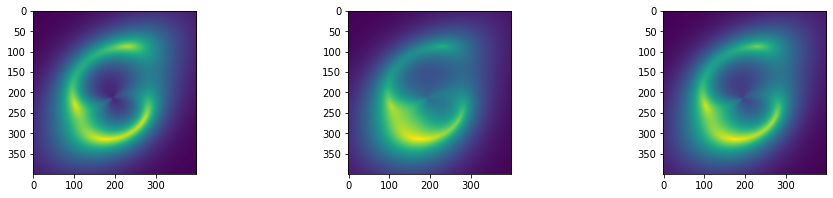

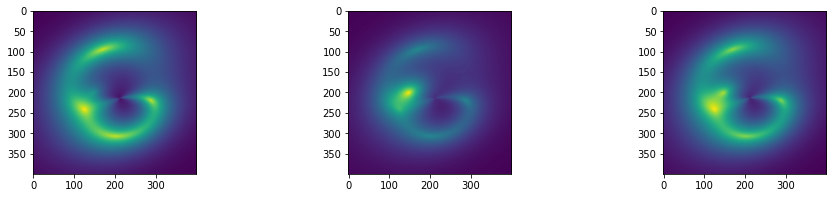

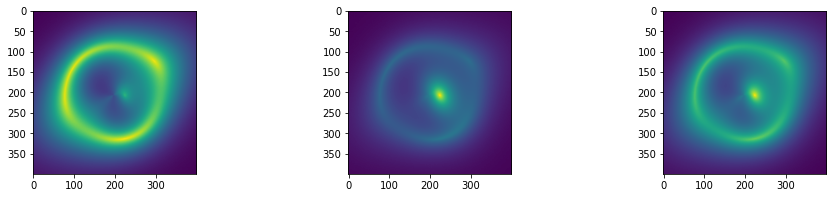

In [6]:
plot_imshow(split_channels(model()), size_y = 3)
plot_imshow(split_channels(model()), size_y = 3)
plot_imshow(split_channels(obs), size_y = 3)

In [7]:
from clipppy.stochastic import Sampler

def set_init(values):
    for lens in values:
        for spec in lens.stochastic_specs.values():
            if isinstance(spec, Sampler):
                name = lens.stochastic_name + '/' + spec.name
                if name in PARAMS['init']: 
                    spec.init = spec.infer['init'] = PARAMS['init'][name]
                    print(f'{name} \t set to {spec.init}')

                    
model.lenslight['sersic2'].stochastic_specs['phi'] = PARAMS['truth']['sersic2/phi']
                    
set_init(model.lenslight.values())
set_init(model.alphas.values())
set_init(model.sources.values())



sersic2/x 	 set to 0
sersic2/y 	 set to 0
sersic2/q 	 set to 1.0
sersic2/index 	 set to 1.0
sersic2/r_e 	 set to 1.0
sersic2/I_e 	 set to 1.0
ext/gamma_1 	 set to 0.0
ext/gamma_2 	 set to 0.0
main/phi 	 set to 0.5
main/q 	 set to 0.5
main/r_ein 	 set to 1.42
main/x 	 set to 0.0
main/y 	 set to 0.0


/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:113: RuntimeWarning: Setting items on StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level.
  warn(f'Setting items on {type(self).__name__} by name is frowned upon'
/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:129: RuntimeWarning: Iterating values from StochasticSpecs is frowned upon and returns the raw specs!
  warn(f'Iterating values from {type(self).__name__} is frowned upon'


In [8]:
# for i in range(nbatch):
#     print(f'starting batch {i}')
    
#     values = [model.lenslight.values(), model.alphas.values(), model.sources.values()]
    
#     for m in values:
#         set_init(values)
        
#     pyro.clear_param_store()
#     guide.setup()
#     losses = []

In [9]:

guide.setup()

guide

Guide(
  (MultivariateNormal): MultivariateNormalSamplingGroup(13 sites, torch.Size([13]))
)

In [10]:
if not os.path.isfile(guide_name):
    print('Training!')

    guide.train() 
    # losses += config.fit(lr=1e-2, n_steps=1000)
    losses = config.fit()
    
    torch.save(losses, losses_name)
    torch.save(guide, guide_name)

else: 
    print('Already traied!')

print('Loading!')
guide = config.guide = torch.load(guide_name)
losses = torch.load(losses_name)

Already traied!
Loading!


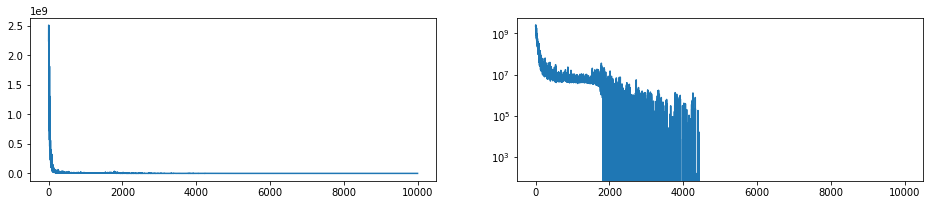

In [11]:
plot_log(losses, size_y = 3)

In [12]:
with pyro.plate('plate', 100000):
    ppd = config.guide()

param_names = []
for k, v in ppd.items():
    ppd[k] = v.detach().numpy() # detach postior
    param_names.append(k) # get names of params

In [13]:
params = PARAMS['truth']
truths = [params.get(k, None) for k in ppd.keys()]

mode = params.copy()
for param_name in param_names:
    y, x = np.histogram(ppd[param_name], bins = 50)
    mode[param_name] = (x[np.where(y == y.max())])[0]
    
mean = params.copy()
for k, v in ppd.items():
    mean[k] = v.mean()
    
labels = [f'{name}={truth:.2f}' for name, truth in zip(param_names, truths)]

ext/gamma_1	truth 0.00700, mode 0.00697, mean 0.00699
ext/gamma_2	truth 0.01000, mode 0.01064, mean 0.01068
main/phi	truth 1.00000, mode 0.99980, mean 1.00031
main/q	truth 0.75000, mode 0.75038, mean 0.75044
main/r_ein	truth 1.50000, mode 1.49988, mean 1.50008
main/x	truth -0.05000, mode -0.05044, mean -0.05034
main/y	truth 0.10000, mode 0.09996, mean 0.09998
sersic2/x	truth 0.30000, mode 0.30023, mean 0.30024
sersic2/y	truth 0.10000, mode 0.10038, mean 0.10050
sersic2/q	truth 1.40000, mode 1.40002, mean 1.40025
sersic2/index	truth 1.10000, mode 1.09854, mean 1.09916
sersic2/r_e	truth 0.90000, mode 0.90105, mean 0.90107
sersic2/I_e	truth 1.10000, mode 1.09897, mean 1.09936


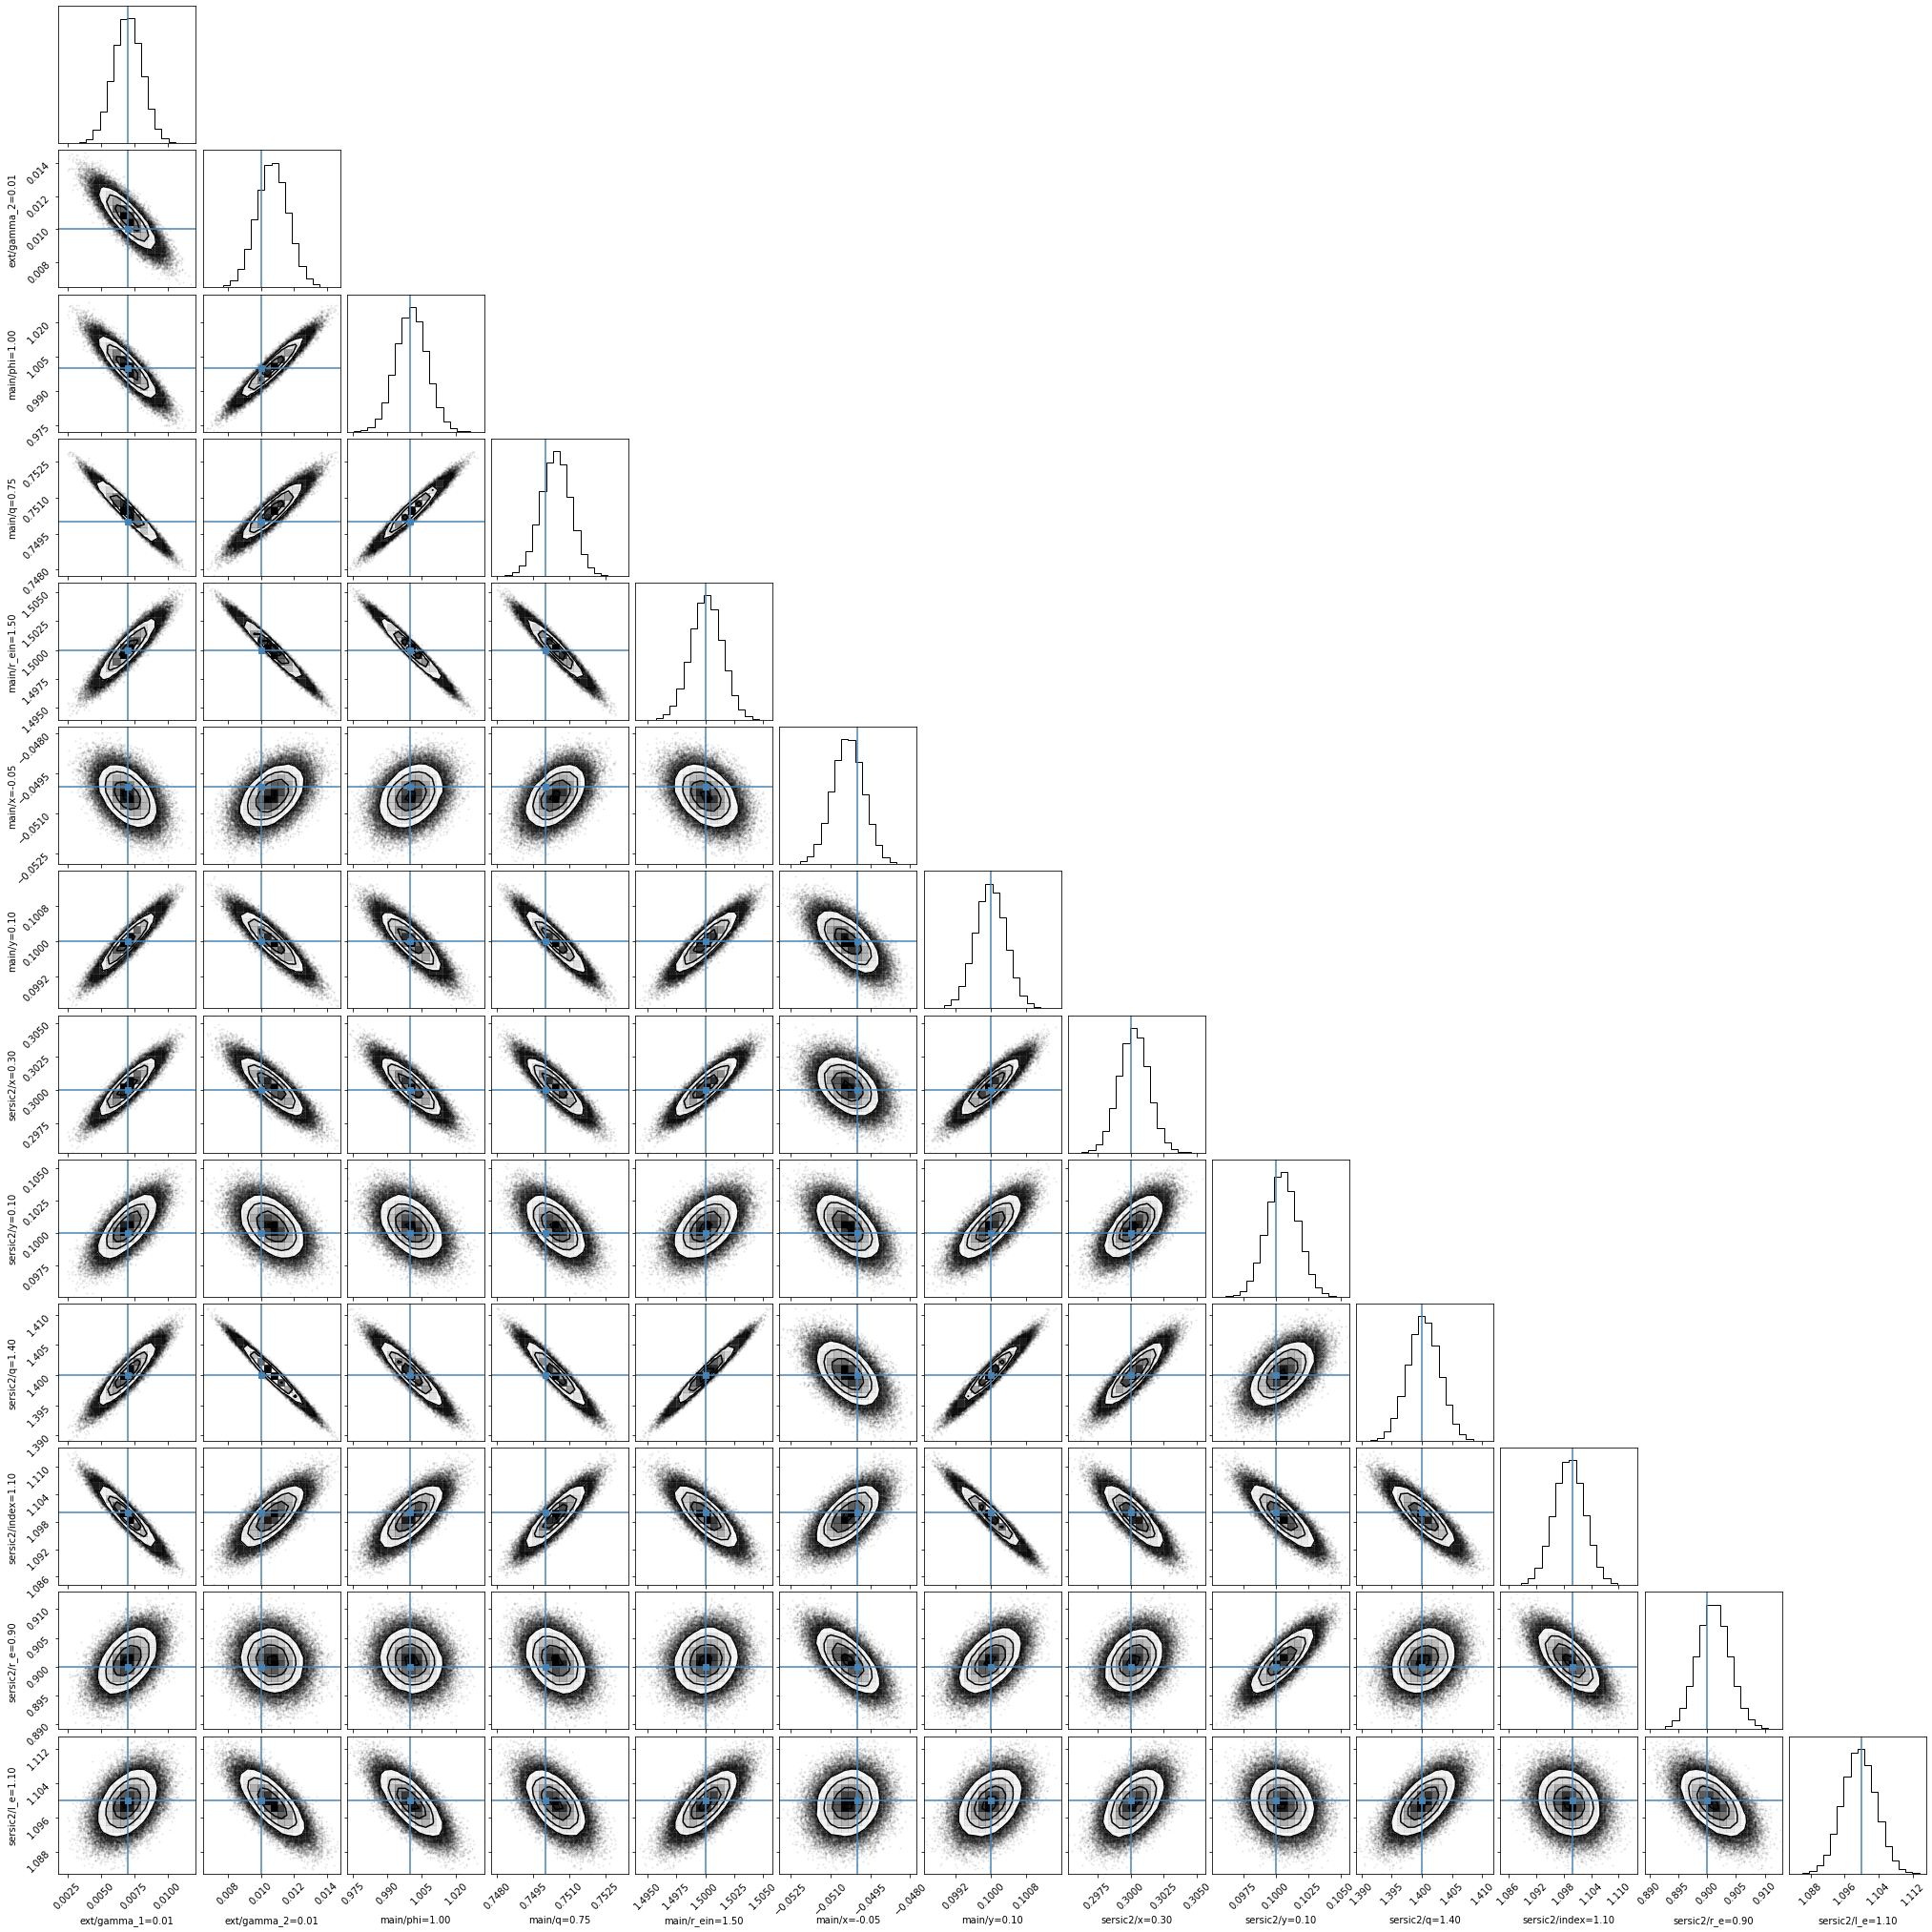

In [14]:
for k, v in ppd.items(): 
    print(f'{k}\ttruth {params[k]:.5f}, mode {mode[k]:.5f}, mean {mean[k]:.5f}')
corner.corner( np.stack(list(ppd.values()), -1), truths = truths, labels = labels);

In [17]:
pred = config.ppd()['model_trace'].nodes['image']['value'] # OR ['mu'] in stead of ['image']?
with pyro.poutine.trace() as tracer, pyro.condition(data=mean): mean_pred = model()
with pyro.poutine.trace() as tracer, pyro.condition(data=mode): mode_pred = model()

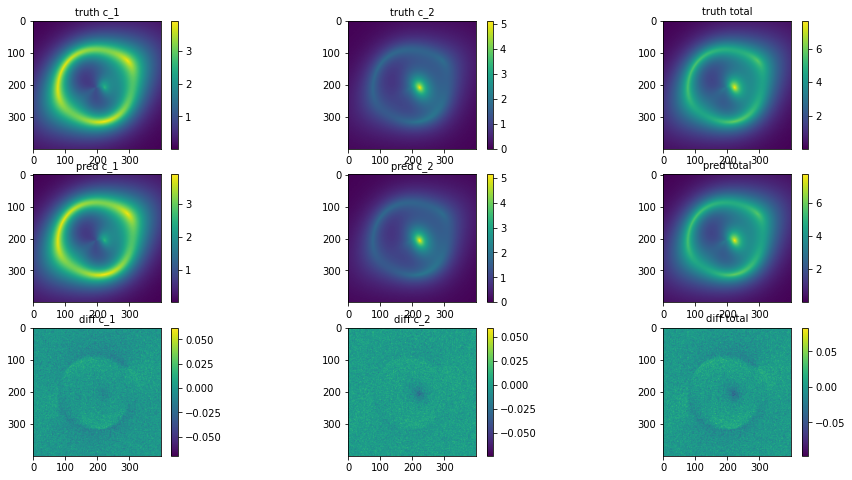

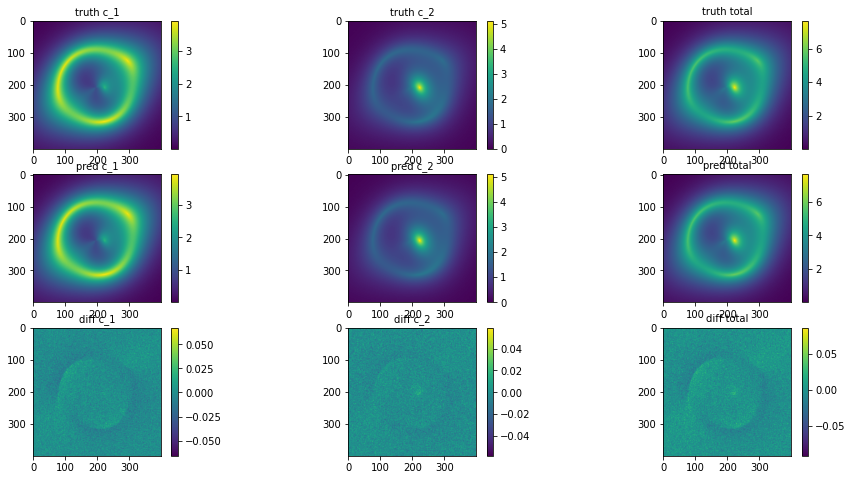

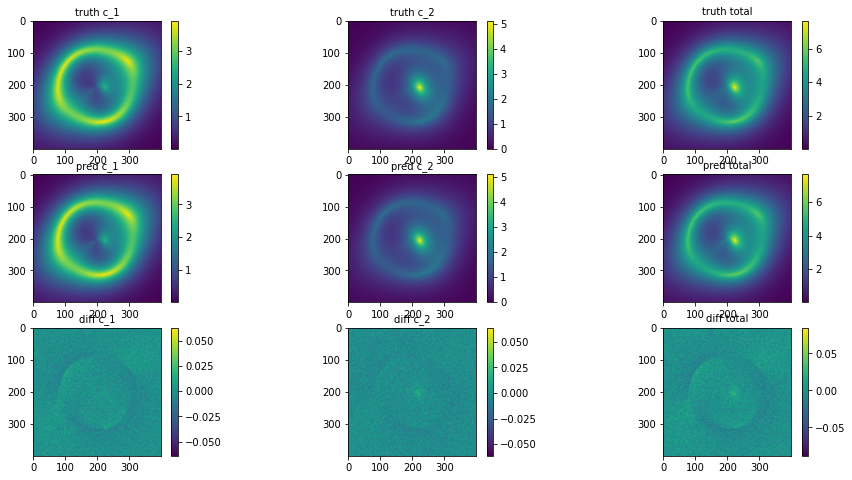

In [18]:
for p in [pred, mean_pred, mode_pred]:
    obss  = split_channels(obs)
    preds = split_channels(p)
    # diffs = [o - p for o, p in zip(obss, preds)]
    diffs = (obss - preds)
    plots = torch.cat((obss, preds, diffs))
    titles = ['truth c_1', 'truth c_2', 'truth total', 'pred c_1', 'pred c_2', 'pred total', 'diff c_1', 'diff c_2', 'diff total']
    plot_imshow(plots, 3, colorbar = True, titles = titles)

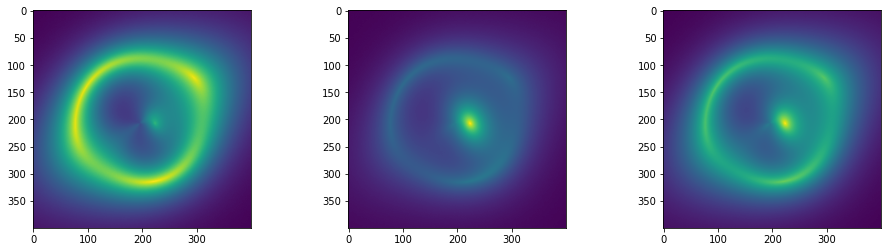

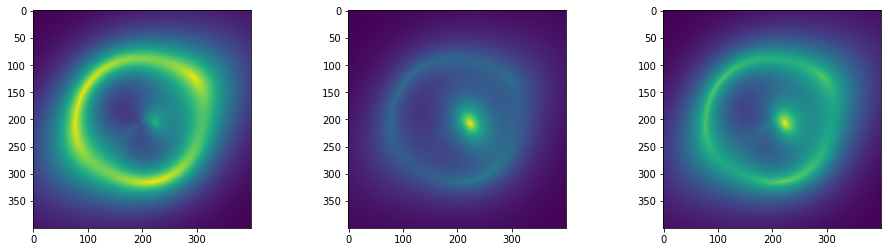

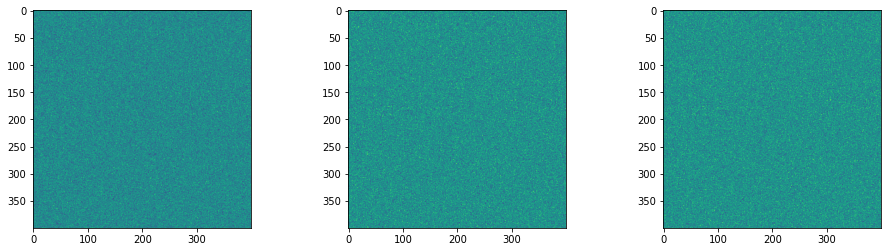

In [19]:
# obs = config.conditioning['image']
with pyro.poutine.trace() as tracer, pyro.condition(data=PARAMS['truth']):
    OBS = model()

plot_imshow(split_channels(obs), size_y = 4)
plot_imshow(split_channels(OBS), size_y = 4)
plot_imshow(split_channels(obs - OBS), size_y = 4)

In [20]:
# plots = [obs, pred, pred-obs, obs, mode_pred, mode_pred-obs, obs, mean_pred, mean_pred-obs, mode_pred, mean_pred, mode_pred - mean_pred]
# titles = ['truth', 'mu pred', 'diff truth and mu pred', 'truth', 'mode pred', 'diff truth and mode pred', 'truth', 'mean pred', 'diff truth and mean pred', 'mode pred', 'mean pred', 'diff mode pred and mean pred']
# plot_imshow(plots = plots, nrows = 4, colorbar = True, titles = titles)